In [1]:
# autoreload python modules on the fly when its source is changed
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from __future__ import division


import requests
import bs4
import pandas as pd
import numpy as np
import time
import re
import traceback
import pickle
from os.path import exists, isfile, join
from optparse import OptionParser
import os
import json
from collections import OrderedDict
import codecs
from IPython.core.display import display, HTML, Markdown
import py_d3
py_d3.load_ipython_extension(get_ipython())
import seaborn as sns

import treelib
from treelib import Node, Tree
import mistune

import utils

## Статистика

In [2]:
df = pd.read_csv('main_topics.csv')
df

,href,id,title
0,https://glav.su/forum/3/,3,ЭКОНОМИЧЕСКИЙ РАЗДЕЛ
1,https://glav.su/forum/4/,4,ПОЛИТИЧЕСКИЙ РАЗДЕЛ
2,https://glav.su/forum/5/,5,ВОЕННЫЙ РАЗДЕЛ
3,https://glav.su/forum/2/,2,НАУЧНО-ТЕХНИЧЕСКИЙ РАЗДЕЛ
4,https://glav.su/forum/13/,13,ИСТОРИЧЕСКИЙ РАЗДЕЛ
5,https://glav.su/forum/12/,12,АВТОРСКИЙ РАЗДЕЛ
6,https://glav.su/forum/1/,1,ПОЛЬЗОВАТЕЛЬСКИЙ РАЗДЕЛ
7,https://glav.su/forum/7/,7,ТЕХНИЧЕСКИЙ РАЗДЕЛ


In [3]:
df_topics = pd.read_csv('topics_all.csv', parse_dates=['datetime'])
df_topics

,author_id,author_name,href,is_blocked,is_bold,last_datetime,main_tid,tid,title,datetime,tag1,tag2,tag3
0,20829,Osq,https://glav.su/forum/3/8/,False,True,Вчера в 21:54,3,8,Мировой экономический кризис,2017-12-17 21:54:00,NaN,NaN,NaN
1,40326,AGROVID.COM,https://glav.su/forum/3/15/,False,True,03.12.17 10:06,3,15,Рынок недвижимости: состояние и перспективы,2017-03-12 10:06:00,NaN,NaN,NaN
2,40321,Nokia22,https://glav.su/forum/3/2452/,False,True,01.12.17 16:50,3,2452,Санкции в отношении России,2017-01-12 16:50:00,NaN,NaN,NaN
3,40073,Брустер,https://glav.su/forum/3/777/,False,True,01.12.17 12:44,3,777,Социология и этика кризиса,2017-01-12 12:44:00,NaN,NaN,NaN
4,18333,Борменталь,https://glav.su/forum/3/206/,False,True,09.09.17 14:09,3,206,FAQ или сборник основных идей,2017-09-09 14:09:00,NaN,NaN,NaN
5,16955,Поверонов,https://glav.su/forum/3/10/,False,False,Вчера в 23:51,3,10,Новая парадигма,2017-12-17 23:51:00,NaN,NaN,NaN
6,40170,Bor7777,https://glav.su/forum/3/40/,False,False,Вчера в 14:59,3,40,Золото,2017-12-17 14:59:00,NaN,NaN,NaN
7,28238,А вон турист,https://glav.su/forum/3/13/,False,False,16.12.17 14:33,3,13,Сбережения и инвестиции,2017-12-16 14:33:00,NaN,NaN,NaN
8,8463,USHBA,https://glav.su/forum/3/2351/,False,False,15.12.17 20:33,3,2351,Bitcoin. Добро или зло?,2017-12-15 20:33:00,NaN,NaN,NaN
9,18809,NetGhost,https://glav.su/forum/3/22/,False,False,13.12.17 19:11,3,22,Модернизация России,2017-12-13 19:11:00,NaN,NaN,NaN


/home/.virtualenvs/drivers2/local/lib/python2.7/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


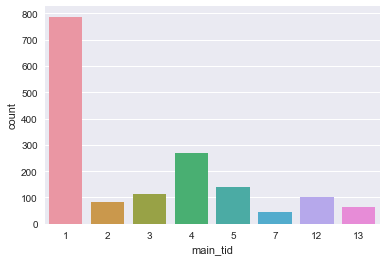

In [4]:
sns.countplot(x='main_tid', data=df_topics)
pass

In [5]:
mask = (df_topics['datetime'] > '2017-09-01') & (df_topics['datetime'] <= '2017-12-31')

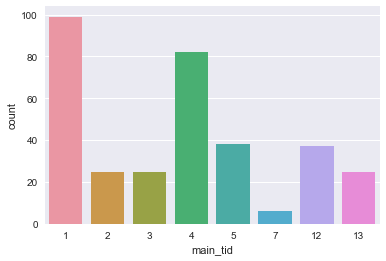

In [6]:
sns.countplot(x='main_tid', data=df_topics.loc[mask])
pass

## Check topics tags

In [7]:
with codecs.open('tree.md', 'r', 'utf-8') as f:
    tree_md = f.read()
Markdown(tree_md)


- [ПОЛИТИЧЕСКИЙ РАЗДЕЛ](https://glav.su/forum/4/)
  - Геополитика
    - Россия
    - Украина
    - Постсоветское пространство
      - Армения
      - Грузия
      - Казахстан
      - Киргизия
      - Туркмения
    - Ближний восток
      - Курды
      - Иран
    - Европа
    - США
    - Другие страны
      - Япония
      - Шотландия
      - КНДР
      - Турция
      - Китай
    - Общие вопросы, теория
      - Инфраструктура
      - Вооружение
  - Информационные войны
  - Отстойник (и спам)


In [8]:
tree = utils.parse_tree(tree_md)
tree.show()

root
└── ПОЛИТИЧЕСКИЙ РАЗДЕЛ
    ├── Геополитика
    │   ├── Ближний восток
    │   │   ├── Иран
    │   │   └── Курды
    │   ├── Другие страны
    │   │   ├── КНДР
    │   │   ├── Китай
    │   │   ├── Турция
    │   │   ├── Шотландия
    │   │   └── Япония
    │   ├── Европа
    │   ├── Общие вопросы, теория
    │   │   ├── Вооружение
    │   │   └── Инфраструктура
    │   ├── Постсоветское пространство
    │   │   ├── Армения
    │   │   ├── Грузия
    │   │   ├── Казахстан
    │   │   ├── Киргизия
    │   │   └── Туркмения
    │   ├── Россия
    │   ├── США
    │   └── Украина
    ├── Информационные войны
    └── Отстойник (и спам)



In [9]:
df_topics = pd.read_csv('topics_all.csv', parse_dates=['datetime'], encoding='utf8')
df_topics

,author_id,author_name,href,is_blocked,is_bold,last_datetime,main_tid,tid,title,datetime,tag1,tag2,tag3
0,20829,Osq,https://glav.su/forum/3/8/,False,True,Вчера в 21:54,3,8,Мировой экономический кризис,2017-12-17 21:54:00,NaN,NaN,NaN
1,40326,AGROVID.COM,https://glav.su/forum/3/15/,False,True,03.12.17 10:06,3,15,Рынок недвижимости: состояние и перспективы,2017-03-12 10:06:00,NaN,NaN,NaN
2,40321,Nokia22,https://glav.su/forum/3/2452/,False,True,01.12.17 16:50,3,2452,Санкции в отношении России,2017-01-12 16:50:00,NaN,NaN,NaN
3,40073,Брустер,https://glav.su/forum/3/777/,False,True,01.12.17 12:44,3,777,Социология и этика кризиса,2017-01-12 12:44:00,NaN,NaN,NaN
4,18333,Борменталь,https://glav.su/forum/3/206/,False,True,09.09.17 14:09,3,206,FAQ или сборник основных идей,2017-09-09 14:09:00,NaN,NaN,NaN
5,16955,Поверонов,https://glav.su/forum/3/10/,False,False,Вчера в 23:51,3,10,Новая парадигма,2017-12-17 23:51:00,NaN,NaN,NaN
6,40170,Bor7777,https://glav.su/forum/3/40/,False,False,Вчера в 14:59,3,40,Золото,2017-12-17 14:59:00,NaN,NaN,NaN
7,28238,А вон турист,https://glav.su/forum/3/13/,False,False,16.12.17 14:33,3,13,Сбережения и инвестиции,2017-12-16 14:33:00,NaN,NaN,NaN
8,8463,USHBA,https://glav.su/forum/3/2351/,False,False,15.12.17 20:33,3,2351,Bitcoin. Добро или зло?,2017-12-15 20:33:00,NaN,NaN,NaN
9,18809,NetGhost,https://glav.su/forum/3/22/,False,False,13.12.17 19:11,3,22,Модернизация России,2017-12-13 19:11:00,NaN,NaN,NaN


In [10]:
for tag in utils.get_unique_tags(df_topics):
    print(tag)

4 Армения
4 Ближний восток
4 Вооружение
4 Грузия
4 Другие страны
4 Европа
4 Информационные войны
4 Инфраструктура
4 Иран
4 КНДР
4 Казахстан
4 Киргизия
4 Китай
4 Курды
4 Общие вопросы, теория
4 Отстойник (и спам)
4 ПОЛИТИЧЕСКИЙ РАЗДЕЛ
4 Постсоветское пространство
4 Россия
4 США
4 Туркмения
4 Турция
4 Украина
4 Шотландия
4 Япония


In [11]:
absents, indices = utils.check_tags(tree, df_topics)

In [12]:
utils.print_absents(absents, indices, df_topics)

## Построение дерева списка тем

### Исходные данные

In [13]:
with codecs.open('tree.md', 'r', 'utf-8') as f:
    tree_md = f.read()
Markdown(tree_md)

- [ПОЛИТИЧЕСКИЙ РАЗДЕЛ](https://glav.su/forum/4/)
  - Геополитика
    - Россия
    - Украина
    - Постсоветское пространство
      - Армения
      - Грузия
      - Казахстан
      - Киргизия
      - Туркмения
    - Ближний восток
      - Курды
      - Иран
    - Европа
    - США
    - Другие страны
      - Япония
      - Шотландия
      - КНДР
      - Турция
      - Китай
    - Общие вопросы, теория
      - Инфраструктура
      - Вооружение
  - Информационные войны
  - Отстойник (и спам)


In [14]:
tree = utils.parse_tree(tree_md)
tree.show()

root
└── ПОЛИТИЧЕСКИЙ РАЗДЕЛ
    ├── Геополитика
    │   ├── Ближний восток
    │   │   ├── Иран
    │   │   └── Курды
    │   ├── Другие страны
    │   │   ├── КНДР
    │   │   ├── Китай
    │   │   ├── Турция
    │   │   ├── Шотландия
    │   │   └── Япония
    │   ├── Европа
    │   ├── Общие вопросы, теория
    │   │   ├── Вооружение
    │   │   └── Инфраструктура
    │   ├── Постсоветское пространство
    │   │   ├── Армения
    │   │   ├── Грузия
    │   │   ├── Казахстан
    │   │   ├── Киргизия
    │   │   └── Туркмения
    │   ├── Россия
    │   ├── США
    │   └── Украина
    ├── Информационные войны
    └── Отстойник (и спам)



In [15]:
df = pd.read_csv('main_topics.csv', encoding='utf8')
df

,href,id,title
0,https://glav.su/forum/3/,3,ЭКОНОМИЧЕСКИЙ РАЗДЕЛ
1,https://glav.su/forum/4/,4,ПОЛИТИЧЕСКИЙ РАЗДЕЛ
2,https://glav.su/forum/5/,5,ВОЕННЫЙ РАЗДЕЛ
3,https://glav.su/forum/2/,2,НАУЧНО-ТЕХНИЧЕСКИЙ РАЗДЕЛ
4,https://glav.su/forum/13/,13,ИСТОРИЧЕСКИЙ РАЗДЕЛ
5,https://glav.su/forum/12/,12,АВТОРСКИЙ РАЗДЕЛ
6,https://glav.su/forum/1/,1,ПОЛЬЗОВАТЕЛЬСКИЙ РАЗДЕЛ
7,https://glav.su/forum/7/,7,ТЕХНИЧЕСКИЙ РАЗДЕЛ


In [16]:
df_topics = pd.read_csv('topics_all.csv', parse_dates=['datetime'], encoding='utf8')

In [17]:
absents, indices = utils.check_tags(tree, df_topics)
utils.print_absents(absents, indices, df_topics)

### Построение дерева

Для каждого топика определяем к какой категории(й) дерева он относится, и прикрепляем его


In [18]:
topics_tree = utils.create_topics_tree(tree, df_topics)

In [19]:
topics_tree.show()

root
└── ПОЛИТИЧЕСКИЙ РАЗДЕЛ
    ├── Беларусь: проблема геополитического выбора
    ├── Большой передел мира
    ├── Выбор России: текущая политическая ситуация
    ├── Выбор США: текущая политическая ситуация
    ├── Геополитика
    │   ├── Ближний восток
    │   │   ├── Арабская весна
    │   │   ├── Армения vs Турция. Арбитраж Вудро Вильсона.
    │   │   ├── Иблиское Государство ДАИШ - нацистский проект
    │   │   ├── Иран
    │   │   │   └── Иран и Ближний Восток.
    │   │   ├── Иран и Ближний Восток.
    │   │   ├── Крах нео-османской Турции
    │   │   ├── Курдский фактор
    │   │   ├── Курды
    │   │   │   └── Курдский фактор
    │   │   ├── Референдум в Иракском Курдистане
    │   │   ├── Турция сегодня
    │   │   └── Убийство российского посла в Турции
    │   ├── Другие страны
    │   │   ├── ...плюс-минус газификация всей Европы
    │   │   ├── Армения vs Турция. Арбитраж Вудро Вильсона.
    │   │   ├── БРИКС
    │   │   ├── Бежнцы, и стратегическая ошибка Европы
    │ 

### Export в markdown

In [20]:
topics_md = utils.topics_tree_2_markdown(topics_tree)

In [21]:
Markdown(topics_md)

  - [ПОЛИТИЧЕСКИЙ РАЗДЕЛ](https://glav.su/forum/4/)
    - **[Большой передел мира](https://glav.su/forum/4/16/)**
    - **[Перспективы развития России](https://glav.su/forum/4/9/)**
    - **[Украинско-российские отношения](https://glav.su/forum/4/38/)**
    - **[Выбор России: текущая политическая ситуация](https://glav.su/forum/4/1340/)**
    - **[Беларусь: проблема геополитического выбора](https://glav.su/forum/4/72/)**
    - **[Пресс-конференция В.В.Путина 14 декабря 2017 года](https://glav.su/forum/4/3237/)**
    - **[Ситуация в Сирии](https://glav.su/forum/4/1624/)**
    - **[Донбасс - путь Домой (Вестник Новороссии)](https://glav.su/forum/4/2368/)**
    - **[Выбор США: текущая политическая ситуация](https://glav.su/forum/4/46/)**
    - **[Интеграция на постсоветском пространстве: стратегии Российского государства](https://glav.su/forum/4/2183/)**
    - Геополитика
      - Россия
        - [Российский Крым](https://glav.su/forum/4/2376/)
        - [Борьба с коррупцией](https://glav.su/forum/4/1875/)
        - [Российско-турецкие отношения](https://glav.su/forum/4/2734/)
        - [Иду на вы. Российская империя-возрождение & Евразийский союз.](https://glav.su/forum/4/1444/)
        - [По материалам "ИЗБОРСКОГО КЛУБА", о России, мире, и нашем месте в нём, политика&экономика&социум](https://glav.su/forum/4/2862/)
        - [русская эволюция 5-го марта](https://glav.su/forum/4/1664/)
        - [Расколется ли «ЕдРо»?(см. Известия)  Что важнее-слово данное ДАМ или народу?](https://glav.su/forum/4/1701/)
        - ~~[Глава Хакасии посоветовал бедным муниципалитетам варить тушенку](https://glav.su/forum/4/3212/)~~
        - ~~[Депутат Госдумы записала клип о готовности детей умереть за Путина](https://glav.su/forum/4/3211/)~~
        - [Крушение Ту-154](https://glav.su/forum/4/2989/)
        - ~~[Нужен всероссийский «мозговой штурм» к столетию Февральской и Октябрьской революций](https://glav.su/forum/4/3050/)~~
        - ~~[Национальный вопрос в России](https://glav.su/forum/4/1436/)~~
        - ~~[Работники Высшей Школы Экономики попали в эпицентр гомосексуального скандала](https://glav.su/forum/4/3198/)~~
        - ~~[Как прошли митинги в поддержку Навального?](https://glav.su/forum/4/3184/)~~
        - [Реформа РАН](https://glav.su/forum/4/2180/)
        - [Будет ли новая смута в России?](https://glav.su/forum/4/3164/)
        - [ Жизнь Российского Телемедийного пространства](https://glav.su/forum/4/2117/)
        - ~~[Чей Крым](https://glav.su/forum/4/3156/)~~
        - ~~[Роковая ошибка Сталина](https://glav.su/forum/4/3154/)~~
        - [Феномен Сталина](https://glav.su/forum/4/3140/)
        - ~~[Перспективы развития России - 2](https://glav.su/forum/4/3126/)~~
        - [Разговор оппозиционера с охранителем](https://glav.su/forum/4/1735/)
        - [Терешкова](https://glav.su/forum/4/3115/)
        - [Госдума РФ](https://glav.su/forum/4/3114/)
        - [Кому выгоден раскол общества в России и в мире?](https://glav.su/forum/4/2971/)
        - [Радио Глобальной Авантюры](https://glav.su/forum/4/1776/)
        - [Радикализм и экстремизм несистемной оппозиции](https://glav.su/forum/4/1592/)
        - [В Симферополе затопило несколько районов из-за ливня .Ето оружие климата как вы считаете](https://glav.su/forum/4/3100/)
        - [Эмиграция и репатриация в Россию](https://glav.su/forum/4/11/)
        - [Взрыв в метро Санкт-Петербурга (03.04.2017)](https://glav.su/forum/4/3066/)
        - ~~[О том как у нас сажают на основании доносов. Свежий пример.](https://glav.su/forum/4/3073/)~~
        - [На пороге отмены санкций против России](https://glav.su/forum/4/3072/)
        - [Визит Тиллерсона в Москву (12.04.2017)](https://glav.su/forum/4/3070/)
        - [Убийство Дениса Вороненкова в Киеве](https://glav.su/forum/4/3054/)
        - ~~[Митинги оппозиции за отставку Медведева (26.03.2017)](https://glav.su/forum/4/3057/)~~
        - ~~[Демократический манифест 2017](https://glav.su/forum/4/3051/)~~
        - [Есть ли жизнь от Урала до Дальнего Востока?](https://glav.su/forum/4/1857/)
        - [Убийство российского посла в Турции](https://glav.su/forum/4/2996/)
        - [Умер представитель России при ООН Виталий Чуркин](https://glav.su/forum/4/3037/)
        - [России нужна новая идеология](https://glav.su/forum/4/1222/)
        - [Убийство Гиви](https://glav.su/forum/4/3018/)
        - ~~[Европа молчит о "Северном потоке-2" из-за паузы, которую взяли США](https://glav.su/forum/4/3030/)~~
        - [Модернизация России](https://glav.su/forum/4/3020/)
        - [Что принадлежит русским в России?](https://glav.su/forum/4/2908/)
        - ~~[Всё пропало](https://glav.su/forum/4/3005/)~~
        - [Большая пресс-конференция с Владимиром Путиным (23.12.2016)](https://glav.su/forum/4/2987/)
        - [Кто правит бал на ТВ мракобесы и невежды 90х или народ?! С подачи жж М.Шевченко](https://glav.su/forum/4/1698/)
        - ~~[Карго-культ в РФ](https://glav.su/forum/4/2910/)~~
        - [Донбасс - его жизнь и судьба](https://glav.su/forum/4/2658/)
        - [Мемориал НОВОРОССИИ](https://glav.su/forum/4/2460/)
        - [Ассоциация Адвокатов России обнаружила госизмену в космической отрасли](https://glav.su/forum/4/2854/)
        - [Неправильный колониализм русских- и как следствие - их дискриминация в постсоветских странах?](https://glav.su/forum/4/2842/)
        - [Закавказья и Дагестан - автохтонные народы.](https://glav.su/forum/4/2229/)
        - [Алкогольная политика и демография](https://glav.su/forum/4/1389/)
        - [Прямая линия с Владимиром Путиным (14.04.2016)](https://glav.su/forum/4/2816/)
        - [Объективно и Сталин](https://glav.su/forum/4/2813/)
        - ~~[Объективно и Сталин](https://glav.su/forum/4/2812/)~~
        - [Большая пресс-конференция с Владимиром Путиным (17.12.2015)](https://glav.su/forum/4/2744/)
      - Украина
        - [Азербайджан, Молдавия, Грузия, Украина...](https://glav.su/forum/4/2449/)
        - [Катастрофа Boeing MH17 под Донецком](https://glav.su/forum/4/2685/)
        - [Реинтеграция Украины: авантюрные стратегии](https://glav.su/forum/4/2146/)
        - [Украина. Закон об образовании 2017.](https://glav.su/forum/4/3210/)
        - [Прорыв Саакашвили на Украину](https://glav.su/forum/4/3152/)
        - [Проект Фашистская Украина.](https://glav.su/forum/4/2365/)
        - [Я Украинец и Я люблю Газманова но мне запрещают слушать его(((](https://glav.su/forum/4/3113/)
        - [Убийство Дениса Вороненкова в Киеве](https://glav.su/forum/4/3054/)
        - [Взрыв арсенала в Балаклее Харьковской области](https://glav.su/forum/4/3055/)
        - [Убийство Гиви](https://glav.su/forum/4/3018/)
        - [Брожение украинских умов](https://glav.su/forum/4/2824/)
        - [Некое предложение для отрезвления "украинцев"](https://glav.su/forum/4/2891/)
        - [Донбасс - его жизнь и судьба](https://glav.su/forum/4/2658/)
        - [Мемориал НОВОРОССИИ](https://glav.su/forum/4/2460/)
        - ["Правый Сектор"](https://glav.su/forum/4/2785/)
        - [Украинско-российские отношения](https://glav.su/forum/4/2434/)
      - Постсоветское пространство
        - **[Украинско-российские отношения](https://glav.su/forum/4/38/)**
        - [Беларусь. Непредвзято.](https://glav.su/forum/4/3093/)
        - [Казахстан & С А](https://glav.su/forum/4/432/)
        - [Среднеазиатский капкан. Киргизия и др.](https://glav.su/forum/4/990/)
        - [При(-о)@балтика](https://glav.su/forum/4/166/)
        - [Азербайджан, Молдавия, Грузия, Украина...](https://glav.su/forum/4/2449/)
        - [Азербайджан сегодня](https://glav.su/forum/4/2589/)
        - [Армения](https://glav.su/forum/4/2177/)
        - [АРЦАХ - Нагорно-Карабахская Республика](https://glav.su/forum/4/2561/)
        - ~~[Армения и ось Москва-тегеран](https://glav.su/forum/4/3155/)~~
        - [Грузинский гондурас.](https://glav.su/forum/4/150/)
        - [Армения vs Турция. Арбитраж Вудро Вильсона.](https://glav.su/forum/4/2213/)
        - [Украина. Закон об образовании 2017.](https://glav.su/forum/4/3210/)
        - ~~[Армения и Азербайджан](https://glav.su/forum/4/1500/)~~
        - [Туркмения.](https://glav.su/forum/4/1440/)
        - [Молдавия](https://glav.su/forum/4/435/)
        - [Проект Фашистская Украина.](https://glav.su/forum/4/2365/)
        - [Я Украинец и Я люблю Газманова но мне запрещают слушать его(((](https://glav.su/forum/4/3113/)
        - [Абхазия и Южная Осетия: Под сенью дружеских штыков?](https://glav.su/forum/4/1557/)
        - [Приднестровье](https://glav.su/forum/4/1585/)
        - Армения
          - ~~[Армения и ось Москва-тегеран](https://glav.su/forum/4/3155/)~~
        - Грузия
          - [Грузинский гондурас.](https://glav.su/forum/4/150/)
        - Казахстан
          - [Казахстан & С А](https://glav.su/forum/4/432/)
        - Киргизия
          - [Среднеазиатский капкан. Киргизия и др.](https://glav.su/forum/4/990/)
        - Туркмения
          - [Туркмения.](https://glav.su/forum/4/1440/)
      - Ближний восток
        - [Иран и Ближний Восток.](https://glav.su/forum/4/155/)
        - [Турция сегодня](https://glav.su/forum/4/2846/)
        - [Армения vs Турция. Арбитраж Вудро Вильсона.](https://glav.su/forum/4/2213/)
        - [Курдский фактор](https://glav.su/forum/4/2050/)
        - [Арабская весна](https://glav.su/forum/4/1437/)
        - [Крах нео-османской Турции](https://glav.su/forum/4/2161/)
        - [Референдум в Иракском Курдистане](https://glav.su/forum/4/3173/)
        - [Иблиское Государство ДАИШ - нацистский проект](https://glav.su/forum/4/2581/)
        - [Убийство российского посла в Турции](https://glav.su/forum/4/2996/)
        - Курды
          - [Курдский фактор](https://glav.su/forum/4/2050/)
        - Иран
          - [Иран и Ближний Восток.](https://glav.su/forum/4/155/)
      - Европа
        - **[Саморазрушение Европы - конец Старого Света?](https://glav.su/forum/4/1724/)**
        - [...плюс-минус газификация всей Европы](https://glav.su/forum/4/366/)
      - США
        - [Полный список всех военных преступлений Соединённых Штатов Америки.](https://glav.su/forum/4/1709/)
      - Другие страны
        - [Израиль, как Вселенная.Еврейский вопрос -  от Абрама до Абрамовича.](https://glav.su/forum/4/635/)
        - [Турция сегодня](https://glav.su/forum/4/2846/)
        - [Польша: Яблочная Революция "гонор"](https://glav.su/forum/4/2982/)
        - [Российско-турецкие отношения](https://glav.su/forum/4/2734/)
        - [Напряженность на Корейском полуострове](https://glav.su/forum/4/984/)
        - [Япония](https://glav.su/forum/4/855/)
        - [Брит или не брит: референдум о независимости Шотландии](https://glav.su/forum/4/2466/)
        - [Полный список всех военных преступлений Соединённых Штатов Америки.](https://glav.su/forum/4/1709/)
        - [Движение за независимость Каталонии](https://glav.su/forum/4/3151/)
        - [За Китай](https://glav.su/forum/4/123/)
        - [Армения vs Турция. Арбитраж Вудро Вильсона.](https://glav.su/forum/4/2213/)
        - [Правильные вопросы про Северную Корею](https://glav.su/forum/4/2798/)
        - [...плюс-минус газификация всей Европы](https://glav.su/forum/4/366/)
        - [Парламентские выборы в Германии 2017](https://glav.su/forum/4/3016/)
        - ~~[Но пасаран !!!  Испания в разнос?](https://glav.su/forum/4/3167/)~~
        - [Взрыв в лондонском метро (15.09.2017)](https://glav.su/forum/4/3159/)
        - [Бежнцы, и стратегическая ошибка Европы](https://glav.su/forum/4/3138/)
        - [БРИКС](https://glav.su/forum/4/2671/)
        - [Ситуация в Венесуэле](https://glav.su/forum/4/3082/)
        - [Военная операция НАТО в Ливии](https://glav.su/forum/4/1385/)
        - [Европейские монархии](https://glav.su/forum/4/2209/)
        - [Инагурация 45-го президента США Дональда Трампа](https://glav.su/forum/4/3004/)
        - [Брексит и Трамп - два последовательных шага к созданию новой империи?](https://glav.su/forum/4/3067/)
        - [Выборы  во ФРАНЦИИ,  vivre ou ne pas vivre!!!???](https://glav.su/forum/4/3022/)
        - [Теракт в Париже](https://glav.su/forum/4/2726/)
        - [Теракт в Лондоне 22.03.2017](https://glav.su/forum/4/3056/)
        - [Ракетный удар США по авиабазе в Сирии (07.04.2017)](https://glav.su/forum/4/3069/)
        - [Политический кризис в Македонии](https://glav.su/forum/4/2649/)
        - [Ирак - ящик пандоры](https://glav.su/forum/4/2432/)
        - [Золотая Звезда Вьетнама](https://glav.su/forum/4/2422/)
        - [Северная Европа](https://glav.su/forum/4/1838/)
        - [Выборы президента Франции 2017](https://glav.su/forum/4/2998/)
        - [Станет ли Израиль удаленным штатом США?](https://glav.su/forum/4/3079/)
        - [Сербия и б. Югославия](https://glav.su/forum/4/1387/)
        - [Болгарский  Перец](https://glav.su/forum/4/965/)
        - ~~[Переворот в США назначен на 1 мая?](https://glav.su/forum/4/3049/)~~
        - [Индо-пакистанский инцидент](https://glav.su/forum/4/2020/)
        - ~~[Европа молчит о "Северном потоке-2" из-за паузы, которую взяли США](https://glav.su/forum/4/3030/)~~
        - [Мартовская катастрофа в Японии](https://glav.su/forum/4/1431/)
        - [Пятый элемент. США: глобальная ложь.](https://glav.su/forum/4/2991/)
        - [Перед бурей...](https://glav.su/forum/4/2983/)
        - [Куба](https://glav.su/forum/4/1170/)
        - [История геноцида индейцев  режимом США глазами американцев](https://glav.su/forum/4/2898/)
        - [Не ходите, дети, в Африку гулять...](https://glav.su/forum/4/1348/)
        - [Теракт в Ницце](https://glav.su/forum/4/2860/)
        - ~~[Сирийские хроники](https://glav.su/forum/4/1547/)~~
        - [Смена власти в Египте](https://glav.su/forum/4/2188/)
        - [Куба и латинская Америка](https://glav.su/forum/4/2628/)
        - [Цыгане в мире](https://glav.su/forum/4/2804/)
        - [Катастрофа А321 Когалымавиа на Синае](https://glav.su/forum/4/2722/)
        - [Саммит G20 в Анталье 2015](https://glav.su/forum/4/2728/)
        - Япония
          - [Япония](https://glav.su/forum/4/855/)
        - Шотландия
          - [Брит или не брит: референдум о независимости Шотландии](https://glav.su/forum/4/2466/)
        - КНДР
          - [Напряженность на Корейском полуострове](https://glav.su/forum/4/984/)
        - Турция
          - [Российско-турецкие отношения](https://glav.su/forum/4/2734/)
          - [Крах нео-османской Турции](https://glav.su/forum/4/2161/)
        - Китай
          - [За Китай](https://glav.su/forum/4/123/)
      - Общие вопросы, теория
        - [Геополитика в строительстве нации: политические аспекты этнической самоидентификации](https://glav.su/forum/4/2448/)
        - [Государство и Религия.](https://glav.su/forum/4/3000/)
        - [Информационные войны](https://glav.su/forum/4/165/)
        - [ Социализм-коммунизм и левая идея в целом](https://glav.su/forum/4/368/)
        - [Иду на вы. Российская империя-возрождение & Евразийский союз.](https://glav.su/forum/4/1444/)
        - [Реинтеграция Украины: авантюрные стратегии](https://glav.su/forum/4/2146/)
        - [По материалам "ИЗБОРСКОГО КЛУБА", о России, мире, и нашем месте в нём, политика&экономика&социум](https://glav.su/forum/4/2862/)
        - [Что считать оружием в будущем](https://glav.su/forum/4/3064/)
        - [Терроризм и борьба с ним](https://glav.su/forum/4/982/)
        - [ГЛОБАльная ванГА: Глупец, хотел уверить нас, Что бог гласит его устами!](https://glav.su/forum/4/2737/)
        - [Инфраструктура и транспорт как элемент геополитики](https://glav.su/forum/4/1073/)
        - ~~[требуется новая идеология , которая может идеологически объединить практически всех людей нашей стра](https://glav.su/forum/4/3176/)~~
        - [Критика  либерализма](https://glav.su/forum/4/3158/)
        - [Разговор оппозиционера с охранителем](https://glav.su/forum/4/1735/)
        - [Мюнхенская конференция по безопасности 2017](https://glav.su/forum/4/3034/)
        - [Энергетическая Геополитика: на вопросы отвечает Already Yet](https://glav.su/forum/4/2151/)
        - [Про демократию, Россию и США, а так же немного про жизнь.](https://glav.su/forum/4/1061/)
        - ["Инновационный новый политический концепт. Начала Новой Политэкономии, Гармонизм (от слова гармония)](https://glav.su/forum/4/2783/)
        - [Переход от стратегических «звездных войн» к тактическим «сырным операциям»…](https://glav.su/forum/4/1717/)
        - [Алкогольная политика и демография](https://glav.su/forum/4/1389/)
        - [Совершенное рабство.](https://glav.su/forum/4/2810/)
        - Инфраструктура
          - [Инфраструктура и транспорт как элемент геополитики](https://glav.su/forum/4/1073/)
        - Вооружение
          - [Что считать оружием в будущем](https://glav.su/forum/4/3064/)
    - Информационные войны
      - [Павильон прямых зеркал](https://glav.su/forum/4/2240/)
      - [Сетевые войны: США жалуются на победу России](https://glav.su/forum/4/3149/)
      - [Глобальное лицемерие. Что такое демократия?](https://glav.su/forum/4/1510/)
      - [WikiLeaks и все вокруг него](https://glav.su/forum/4/1263/)
      - [Голосовалка](https://glav.su/forum/4/2975/)
      - [Политтехнологии США обкатывает на наших детях!](https://glav.su/forum/4/2923/)
      - [Спокойная лента новостей](https://glav.su/forum/4/2242/)
      - [Кто правит бал на ТВ мракобесы и невежды 90х или народ?! С подачи жж М.Шевченко](https://glav.su/forum/4/1698/)
      - [Переход от стратегических «звездных войн» к тактическим «сырным операциям»…](https://glav.su/forum/4/1717/)
      - [Дочери офицеров, ольгинцы, порохоботы и прочие.](https://glav.su/forum/4/2811/)
      - [Эдвард Сноуден: Разоблачения](https://glav.su/forum/4/2165/)
    - Отстойник (и спам)
      - [Отстойник Выбора](https://glav.su/forum/4/3065/)
      - [КОГДА МОЖНО УСТАНАВЛИВАТЬ ИМПЛАНТ НА МЕСТЕ УДАЛЕННОГО ЗУБА](https://glav.su/forum/4/3205/)
      - ~~[Флуд звонками. Все страны.Без ограничений в потоках.](https://glav.su/forum/4/3196/)~~
      - ~~[Партнёрство](https://glav.su/forum/4/3040/)~~
      - [Заработок от 6000 рублей в день](https://glav.su/forum/4/3047/)
      - [Большой передел мира](https://glav.su/forum/4/3028/)
      - ~~[DANTV](https://glav.su/forum/4/3019/)~~
      - [Перед бурей...](https://glav.su/forum/4/2983/)
      - ~~[как быстро разрядить автомат -](https://glav.su/forum/4/2850/)~~
      - [Нам предлагают самоликвидацию!](https://glav.su/forum/4/1346/)
      - [СТАВКИ НА СПОРТ](https://glav.su/forum/4/2787/)


In [22]:
with codecs.open('topics_generated.md', 'w', 'utf-8') as f:
    f.write(topics_md)